### Notebook to process benchmar results

Please run this notebook after running all the benchmarks and storing them in the `results` dir. This will export them in the desired format for the single node benchmark plots of [qdrant.tech/benchmarks](https://qdrant.tech/benchmarks)

In [1]:
from pathlib import Path
import re
import json
import pandas as pd
from datetime import datetime, timezone

In [2]:
DATA_DIR = Path().resolve().parent / "results"
DATA_DIR, list(DATA_DIR.glob("*.json"))[0].name

(PosixPath('/home/gerson/Projects/Personal/vector-db-benchmark/results'),
 'pgvector-m-64-ef-512-glove-100-angular-search-2-2024-08-13-01-28-36.json')

In [3]:
PATH_REGEX = re.compile(r"(?P<engine_name>("
                        r"?P<engine>[a-z\-]+)"
                        r"\-m\-(?P<m>[0-9]+)"
                        r"\-ef\-(?P<ef>[0-9]+)"
                        r")"
                        r"\-(?P<dataset>[a-zA-Z0-9\-]+)"
                        r"\-(?P<operation>(search)|(upload))"
                        r"(\-(?P<search_index>[0-9]{1,2})\-)?"
                        r"\-?(?P<date>.*)\.json")

In [4]:
upload_results, search_results = [], []

for path in DATA_DIR.glob("*.json"):
    match = PATH_REGEX.match(path.name)
    if match is None:
        continue

    experiment = match.groupdict()

    with open(path, "r") as fp:
        stats = json.load(fp)

    params = stats["params"]
    dataset = params.pop("dataset")
    engine = params.pop("engine")

    entry = {
        "dataset": dataset,
        "engine": engine,
        "m": match["m"],
        "ef": match["ef"],
        "date": match["date"],
        "params": params,
        "results": stats["results"],
    }

    if experiment["operation"] == "search":
        entry.update({"search_index": match["search_index"]})
        search_results.append(entry)
    elif experiment["operation"] == "upload":
        upload_results.append(entry)
    else:
        raise Exception("Unknown operation")

len(upload_results), len(search_results)

(20, 78)

In [5]:
upload_results, search_results[0]

([{'dataset': 'glove-100-angular',
   'engine': 'qdrant',
   'm': '64',
   'ef': '256',
   'date': '2024-08-13-01-55-47',
   'params': {'experiment': 'qdrant-m-64-ef-256',
    'parallel': 16,
    'optimizers_config': {'memmap_threshold': 10000000},
    'hnsw_config': {'m': 64, 'ef_construct': 256}},
   'results': {'post_upload': {},
    'upload_time': 21.813324732000183,
    'total_time': 337.2039692759936}},
  {'dataset': 'glove-100-angular',
   'engine': 'elasticsearch',
   'm': '64',
   'ef': '256',
   'date': '2024-08-16-14-42-18',
   'params': {'experiment': 'elasticsearch-m-64-ef-256',
    'parallel': 16,
    'index_options': {'m': 64, 'ef_construction': 256}},
   'results': {'post_upload': {},
    'upload_time': 281.16547881899896,
    'total_time': 2809.3173359230004}},
  {'dataset': 'glove-100-angular',
   'engine': 'qdrant',
   'm': '32',
   'ef': '256',
   'date': '2024-08-13-01-34-53',
   'params': {'experiment': 'qdrant-m-32-ef-256',
    'parallel': 16,
    'optimizers_con

In [6]:
upload_df = pd.DataFrame(upload_results)
upload_df["date"] = pd.to_datetime(upload_df["date"], format="%Y-%m-%d-%H-%M-%S")
upload_df = upload_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset"]) \
    .first()

temp_df = upload_df.copy()
temp_df["total_time"] = temp_df["results"].apply(lambda x: x["total_time"])
temp_df.sort_values("total_time", ascending=True).head(n=5)

date  \
engine   m  ef  dataset                                 
qdrant   32 256 glove-100-angular 2024-08-13 01:34:53   
         64 256 glove-100-angular 2024-08-13 01:55:47   
weaviate 32 256 glove-100-angular 2024-08-13 02:21:37   
qdrant   32 512 glove-100-angular 2024-08-13 01:47:18   
weaviate 64 256 glove-100-angular 2024-08-13 02:52:27   

                                                                              params  \
engine   m  ef  dataset                                                                
qdrant   32 256 glove-100-angular  {'experiment': 'qdrant-m-32-ef-256', 'parallel...   
         64 256 glove-100-angular  {'experiment': 'qdrant-m-64-ef-256', 'parallel...   
weaviate 32 256 glove-100-angular  {'experiment': 'weaviate-m-32-ef-256', 'batch_...   
qdrant   32 512 glove-100-angular  {'experiment': 'qdrant-m-32-ef-512', 'parallel...   
weaviate 64 256 glove-100-angular  {'experiment': 'weaviate-m-64-ef-256', 'batch_...   

                                                                             results  \
engine   m  ef  dataset                                                                
qdrant   32 256 glove-100-angular  {'post_upload': {}, 'upload_time': 22.01401747...   
         64 256 glove-100-angular  {'post_upload': {}, 'upload_time': 21.81332473...   
weaviate 32 256 glove-100-angular  {'post_upload': {}, 'upload_time': 514.3208342...   
qdrant   32 512 glove-100-angular  {'post_upload': {}, 'upload_time': 22.02096416...   
weaviate 64 256 glove-100-angular  {'post_upload': {}, 'upload_time': 635.8062502...   

                                   total_time  
engine   m  ef  dataset                        
qdrant   32 256 glove-100-angular  307.371332  
         64 256 glove-100-angular  337.203969  
weaviate 32 256 glove-100-angular  514.320875  
qdrant   32 512 glove-100-angular  582.626750  
weaviate 64 256 glove-100-angular  635.806296

In [7]:
search_df = pd.DataFrame(search_results)
search_df["date"] = pd.to_datetime(search_df["date"], format="%Y-%m-%d-%H-%M-%S")
search_df = search_df.sort_values("date", ascending=False) \
    .groupby(["engine", "m", "ef", "dataset", "search_index"]) \
    .first()

temp_df = search_df.copy()
temp_df['rps'] = temp_df['results'].apply(lambda x: x["rps"])
temp_df.sort_values("rps", ascending=False).head(n=10)

date  \
engine   m  ef  dataset           search_index                       
weaviate 32 512 glove-100-angular 2            2024-08-13 02:41:24   
            256 glove-100-angular 2            2024-08-13 02:23:28   
         64 256 glove-100-angular 2            2024-08-13 02:54:38   
pgvector 32 256 glove-100-angular 2            2024-08-12 23:17:17   
weaviate 64 512 glove-100-angular 2            2024-08-13 03:20:02   
pgvector 32 512 glove-100-angular 2            2024-08-12 23:50:46   
redis    32 256 glove-100-angular 2            2024-08-12 21:15:41   
            512 glove-100-angular 2            2024-08-12 21:48:31   
         64 256 glove-100-angular 2            2024-08-12 22:11:39   
            512 glove-100-angular 2            2024-08-12 22:57:23   

                                                                                           params  \
engine   m  ef  dataset           search_index                                                      
weaviate 32 512 glove-100-angular 2             {'experiment': 'weaviate-m-32-ef-512', 'parall...   
            256 glove-100-angular 2             {'experiment': 'weaviate-m-32-ef-256', 'parall...   
         64 256 glove-100-angular 2             {'experiment': 'weaviate-m-64-ef-256', 'parall...   
pgvector 32 256 glove-100-angular 2             {'experiment': 'pgvector-m-32-ef-256', 'parall...   
weaviate 64 512 glove-100-angular 2             {'experiment': 'weaviate-m-64-ef-512', 'parall...   
pgvector 32 512 glove-100-angular 2             {'experiment': 'pgvector-m-32-ef-512', 'parall...   
redis    32 256 glove-100-angular 2             {'experiment': 'redis-m-32-ef-256', 'parallel'...   
            512 glove-100-angular 2             {'experiment': 'redis-m-32-ef-512', 'parallel'...   
         64 256 glove-100-angular 2             {'experiment': 'redis-m-64-ef-256', 'parallel'...   
            512 glove-100-angular 2             {'experiment': 'redis-m-64-ef-512', 'parallel'...   

                                                                                          results  \
engine   m  ef  dataset           search_index                                                      
weaviate 32 512 glove-100-angular 2             {'total_time': 4.760768396998174, 'mean_time':...   
            256 glove-100-angular 2             {'total_time': 4.778433592997317, 'mean_time':...   
         64 256 glove-100-angular 2             {'total_time': 5.113684122996347, 'mean_time':...   
pgvector 32 256 glove-100-angular 2             {'total_time': 5.516142790998856, 'mean_time':...   
weaviate 64 512 glove-100-angular 2             {'total_time': 5.5376608459991985, 'mean_time'...   
pgvector 32 512 glove-100-angular 2             {'total_time': 5.5856774329949985, 'mean_time'...   
redis    32 256 glove-100-angular 2             {'total_time': 5.732930912003212, 'mean_time':...   
            512 glove-100-angular 2             {'total_time': 5.931051986000966, 'mean_time':...   
         64 256 glove-100-angular 2             {'total_time': 6.925964413996553, 'mean_time':...   
            512 glove-100-angular 2             {'total_time': 7.680500934002339, 'mean_time':...   

                                                        rps  
engine   m  ef  dataset           search_index               
weaviate 32 512 glove-100-angular 2             2100.501257  
            256 glove-100-angular 2             2092.735999  
         64 256 glove-100-angular 2             1955.537292  
pgvector 32 256 glove-100-angular 2             1812.860975  
weaviate 64 512 glove-100-angular 2             1805.816622  
pgvector 32 512 glove-100-angular 2             1790.293142  
redis    32 256 glove-100-angular 2             1744.308479  
            512 glove-100-angular 2             1686.041536  
         64 256 glove-100-angular 2             1443.842244  
            512 glove-100-angular 2             1301.998409

In [8]:
_search = search_df.reset_index()
_upload = upload_df.reset_index()

joined_df = _search.merge(_upload, on=["engine", "m", "ef", "dataset"], how="left", suffixes=("_search", "_upload"))
print(len(joined_df))
joined_df

78


,engine,m,ef,dataset,search_index,date_search,params_search,results_search,date_upload,params_upload,results_upload
0,elasticsearch,32,256,glove-100-angular,0,2024-08-16 11:48:05,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'total_time': 39.358161053, 'mean_time': 0.00...",2024-08-16 11:47:26,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'post_upload': {}, 'upload_time': 259.2367609..."
1,elasticsearch,32,256,glove-100-angular,1,2024-08-16 11:49:09,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'total_time': 64.11248702000012, 'mean_time':...",2024-08-16 11:47:26,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'post_upload': {}, 'upload_time': 259.2367609..."
2,elasticsearch,32,256,glove-100-angular,2,2024-08-16 11:49:47,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'total_time': 21.176963696999337, 'mean_time'...",2024-08-16 11:47:26,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'post_upload': {}, 'upload_time': 259.2367609..."
3,elasticsearch,32,256,glove-100-angular,3,2024-08-16 11:50:30,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'total_time': 27.142399221999767, 'mean_time'...",2024-08-16 11:47:26,"{'experiment': 'elasticsearch-m-32-ef-256', 'p...","{'post_upload': {}, 'upload_time': 259.2367609..."
4,elasticsearch,32,512,glove-100-angular,0,2024-08-16 13:03:18,"{'experiment': 'elasticsearch-m-32-ef-512', 'p...","{'total_time': 32.58722575499996, 'mean_time':...",2024-08-16 13:02:45,"{'experiment': 'elasticsearch-m-32-ef-512', 'p...","{'post_upload': {}, 'upload_time': 383.6881226..."
...,...,...,...,...,...,...,...,...,...,...,...
73,weaviate,64,256,glove-100-angular,3,2024-08-13 02:55:07,"{'experiment': 'weaviate-m-64-ef-256', 'parall...","{'total_time': 13.301437961003103, 'mean_time'...",2024-08-13 02:52:27,"{'experiment': 'weaviate-m-64-ef-256', 'batch_...","{'post_upload': {}, 'upload_time': 635.8062502..."
74,weaviate,64,512,glove-100-angular,0,2024-08-13 03:18:12,"{'experiment': 'weaviate-m-64-ef-512', 'parall...","{'total_time': 34.95021560099849, 'mean_time':...",2024-08-13 03:17:37,"{'experiment': 'weaviate-m-64-ef-512', 'batch_...","{'post_upload': {}, 'upload_time': 1349.764987..."
75,weaviate,64,512,glove-100-angular,1,2024-08-13 03:19:39,"{'experiment': 'weaviate-m-64-ef-512', 'parall...","{'total_time': 86.89090831700014, 'mean_time':...",2024-08-13 03:17:37,"{'experiment': 'weaviate-m-64-ef-512', 'batch_...","{'post_upload': {}, 'upload_time': 1349.764987..."
76,weaviate,64,512,glove-100-angular,2,2024-08-13 03:20:02,"{'experiment': 'weaviate-m-64-ef-512', 'parall...","{'total_time': 5.5376608459991985, 'mean_time'...",2024-08-13 03:17:37,"{'experiment': 'weaviate-m-64-ef-512', 'batch_...","{'post_upload': {}, 'upload_time': 1349.764987..."


In [9]:
json_results = []

for index, row in joined_df.reset_index().iterrows():
    engine_params = {}
    
    if isinstance(row['params_upload'], dict):
        engine_params.update(row['params_upload'])
    if isinstance(row['params_search'], dict):
        search_params = row['params_search']
        engine_params.update(search_params.get('config', {}))
        engine_params.update(search_params.get('params', {}))
        engine_params.update(search_params.get('search_params', {}))
        engine_params.update(search_params.get('vectorIndexConfig', {}))

    engine_params.pop('experiment')
    engine_params.pop('parallel')

    engine_name = row['engine']

    if engine_name.startswith("qdrant-"):
        engine_name = "qdrant"

    json_object = {
        "engine_name": engine_name,
        "setup_name": f"{row['params_search']['experiment']}",
        "dataset_name": row['dataset'],
        "search_idx": row['search_index'],
        "upload_time": row['results_upload']['upload_time'],
        "total_upload_time": row['results_upload']['total_time'],
        "p95_time": row['results_search']['p95_time'],
        "rps": row['results_search']['rps'],
        "parallel": row['params_search']['parallel'],
        "p99_time": row['results_search']['p99_time'],
        "mean_time": row['results_search']['mean_time'],
        "mean_precisions": row['results_search']['mean_precisions'],
        "engine_params": engine_params,
    }
    json_results.append(json_object)

results_json = []
for j in json_results:
    if j["parallel"] == 1:
        results_json.append(j)

format = '%Y-%M-%dT%H:%M:%S'
now = datetime.now().replace(tzinfo=timezone.utc).strftime(format)

Path(f"../public/files/results.json").write_text(json.dumps(results_json, indent=2))
Path(f"results-{now}.json").write_text(json.dumps(results_json, indent=2))

print(results_json[-1], len(results_json))

results_df = pd.DataFrame(json_results).sort_values("p99_time", ascending=True)
results_df.to_csv('results.csv')
results_df.head()

{'engine_name': 'weaviate', 'setup_name': 'weaviate-m-64-ef-512', 'dataset_name': 'glove-100-angular', 'search_idx': '1', 'upload_time': 1349.7649877160002, 'total_upload_time': 1349.7650205850005, 'p95_time': 0.01404075595564791, 'rps': 115.08683927572095, 'parallel': 1, 'p99_time': 0.0166983394890849, 'mean_time': 0.008579795552051656, 'mean_precisions': 0.9674590000000001, 'engine_params': {'batch_size': 1024, 'vectorIndexConfig': {'efConstruction': 512, 'maxConnections': 64}, 'ef': 512}} 40


,engine_name,setup_name,dataset_name,search_idx,upload_time,total_upload_time,p95_time,rps,parallel,p99_time,mean_time,mean_precisions,engine_params
46,redis,redis-m-32-ef-256,glove-100-angular,0,1024.375903,1024.375950,0.001772,734.725200,1,0.002105,0.001314,0.765863,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 2..."
50,redis,redis-m-32-ef-512,glove-100-angular,0,1872.581663,1872.581707,0.001888,720.262341,1,0.002221,0.001336,0.772473,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 5..."
54,redis,redis-m-64-ef-256,glove-100-angular,0,1282.901898,1282.901943,0.001946,639.900880,1,0.002310,0.001513,0.811210,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 2..."
58,redis,redis-m-64-ef-512,glove-100-angular,0,2628.445094,2628.445146,0.002155,588.902951,1,0.002577,0.001644,0.829536,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 5..."
30,qdrant,qdrant-m-32-ef-256,glove-100-angular,0,22.014017,307.371332,0.003026,386.397706,1,0.003354,0.002499,0.872996,{'optimizers_config': {'memmap_threshold': 100...


In [10]:
# sorted(list(results_df["setup_name"].unique()))
# results_df["engine_name"] = results_df["engine_name"].map(
#     {"weaviate": 3, "redis": 2, "qdrant": 1, "pgvector": 0}
# )
result = results_df.loc[
    # (results_df["mean_precisions"] < 0.95) &
    # (results_df["mean_precisions"] > 0.91) &
    # (results_df["engine_name"] == "weaviate") & 
    (results_df["parallel"] == 1)
]
columns = {
    "search_idx": "pesquisa_id",
    "setup_name": "Configuração",
    "upload_time": "Tempo de Upload (ms)",
    "total_upload_time":"Total",
    "p95_time": "Latência p95 (s)",
    "rps": "RPS",
    "mean_time": "Latência Média (s)",
    "mean_precisions": "Precisão Média",
    "engine_params": "Engine Params",
}
result_final = result.rename(columns=columns).sort_values("Configuração", ascending=True)[list(columns.values())]
# result_final["m"] = result_final.apply(lambda row: str(row["Configuração"]).split("-")[2], axis=1)
# result_final["ef"] = result_final.apply(lambda row: str(row["Configuração"]).split("-")[-1], axis=1)
df = (
    result_final.sort_values("Tempo de Upload (ms)", ascending=False)
    # .groupby(["Configuração", "pesquisa_id"])
    # .first()
)
df.to_csv("results_final.csv")
df

,pesquisa_id,Configuração,Tempo de Upload (ms),Total,Latência p95 (s),RPS,Latência Média (s),Precisão Média,Engine Params
58,0,redis-m-64-ef-512,2628.445094,2628.445146,0.002155,588.902951,0.001644,0.829536,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 5..."
59,1,redis-m-64-ef-512,2628.445094,2628.445146,0.004654,269.782819,0.003625,0.967432,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 5..."
51,1,redis-m-32-ef-512,1872.581663,1872.581707,0.003555,343.554719,0.002835,0.933034,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 5..."
50,0,redis-m-32-ef-512,1872.581663,1872.581707,0.001888,720.262341,0.001336,0.772473,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 5..."
74,0,weaviate-m-64-ef-512,1349.764988,1349.765021,0.005249,286.121268,0.003408,0.829920,"{'batch_size': 1024, 'vectorIndexConfig': {'ef..."
75,1,weaviate-m-64-ef-512,1349.764988,1349.765021,0.014041,115.086839,0.008580,0.967459,"{'batch_size': 1024, 'vectorIndexConfig': {'ef..."
55,1,redis-m-64-ef-256,1282.901898,1282.901943,0.004274,299.272303,0.003262,0.952518,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 2..."
54,0,redis-m-64-ef-256,1282.901898,1282.901943,0.001946,639.900880,0.001513,0.811210,"{'hnsw_config': {'M': 64, 'EF_CONSTRUCTION': 2..."
46,0,redis-m-32-ef-256,1024.375903,1024.375950,0.001772,734.725200,0.001314,0.765863,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 2..."
47,1,redis-m-32-ef-256,1024.375903,1024.375950,0.003471,352.585692,0.002764,0.925242,"{'hnsw_config': {'M': 32, 'EF_CONSTRUCTION': 2..."


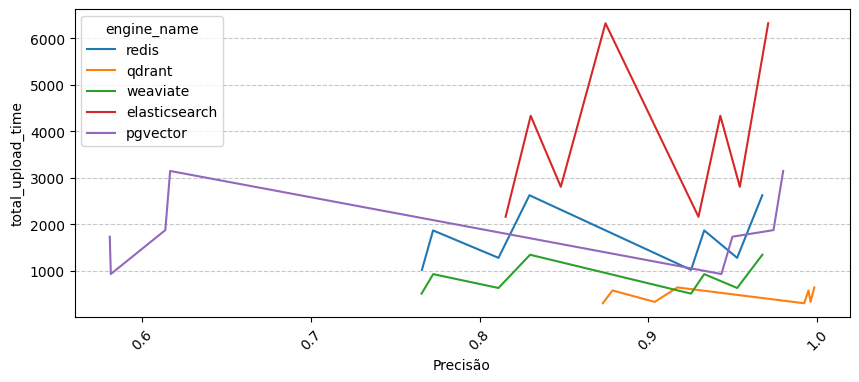

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
# results_df.plot(kind="scatter", x="mean_precisions", y="rps", c="engine_name")
sns.lineplot(x="mean_precisions", y="total_upload_time", hue="engine_name", data=result)
# sns.scatterplot(x="mean_precisions", y="rps", hue="engine_name", data=result)
# plot = sns.FacetGrid(results_df, col="engine_name")
# plot.map(plt.plot, "mean_precisions")
plt.ylabel("total_upload_time")
plt.xlabel("Precisão")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [12]:
result.to_csv("results_filtrados.csv")